# Práctica 3: Embeddings and IA


**Integrantes:**
1. Ceballos Equihua Conan Nathaniel
2. Murrieta Villegas Alfonso
3. Salas Mora Mónica


## 1. Libraries and Loading Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Se carga el dataset obtenido en la tarea anterior (práctica 2).

In [ ]:
urlData = 'https://raw.githubusercontent.com/aMurryFly/nlp_course/main/data/embeddings.csv'
data = pd.read_csv(urlData, encoding='latin1')
data.head()

,Unnamed: 0,category,clean_description,tagged_document,embedding
0,0,BUSINESS,littleknown northern california town establish...,"TaggedDocument(['littleknown', 'northern', 'ca...",[ 4.51545231e-02 -6.51607588e-02 -1.57348052e-...
1,1,BUSINESS,getting crowded investment crowdfunding space ...,"TaggedDocument(['getting', 'crowded', 'investm...",[-0.00253797 -0.11379275 -0.26249868 0.224998...
2,2,BUSINESS,even though might literally sending wrong mess...,"TaggedDocument(['even', 'though', 'might', 'li...",[ 0.05407709 -0.06602132 -0.17997105 0.171666...
3,3,BUSINESS,deal coming soon,"TaggedDocument(['deal', 'coming', 'soon'], ['B...",[ 3.23793963e-02 -1.84102692e-02 -7.04682246e-...
4,4,BUSINESS,many leaders operate meeting brand directly af...,"TaggedDocument(['many', 'leaders', 'operate', ...",[ 1.78402197e-02 -9.09306183e-02 -2.58796155e-...



## 2. EDA (Exploratory Data Analysis)

Drop index column - (Unnamed: 0)

In [ ]:
data = data.drop(['Unnamed: 0'], axis='columns')
data.head()

,category,clean_description,tagged_document,embedding
0,BUSINESS,littleknown northern california town establish...,"TaggedDocument(['littleknown', 'northern', 'ca...",[ 4.51545231e-02 -6.51607588e-02 -1.57348052e-...
1,BUSINESS,getting crowded investment crowdfunding space ...,"TaggedDocument(['getting', 'crowded', 'investm...",[-0.00253797 -0.11379275 -0.26249868 0.224998...
2,BUSINESS,even though might literally sending wrong mess...,"TaggedDocument(['even', 'though', 'might', 'li...",[ 0.05407709 -0.06602132 -0.17997105 0.171666...
3,BUSINESS,deal coming soon,"TaggedDocument(['deal', 'coming', 'soon'], ['B...",[ 3.23793963e-02 -1.84102692e-02 -7.04682246e-...
4,BUSINESS,many leaders operate meeting brand directly af...,"TaggedDocument(['many', 'leaders', 'operate', ...",[ 1.78402197e-02 -9.09306183e-02 -2.58796155e-...


Validación de datos nulos o repetidos

In [ ]:
explordata= data 

nullValues= data.isnull().sum().sort_values(ascending=False)
total =explordata.shape[0]

percent_missing= (explordata.isnull().sum()/total).sort_values(ascending=False)
loss_data= pd.concat([nullValues, percent_missing], axis=1, keys=['Datos nulos', 'Porcetaje'])
print (loss_data)

                   Datos nulos  Porcetaje
embedding                    0        0.0
tagged_document              0        0.0
clean_description            0        0.0
category                     0        0.0


Cantidad de datos o documentos

In [ ]:
print('Total de datos: ', explordata.shape[0])

Total de datos:  29950


Distribución de las categorías de noticias

In [ ]:
pre_class_allData = explordata.groupby('category').count()['clean_description'].reset_index().sort_values(by='clean_description',ascending=False)
percent_class= pre_class_allData.clean_description
labels= pre_class_allData.category

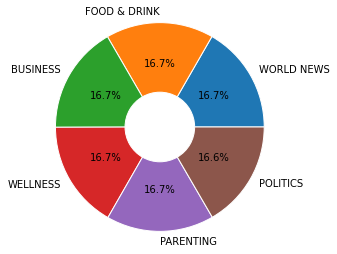

In [ ]:
my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,autopct="%.1f%%")
plt.setp(my_pie, width=0.8, edgecolor='white') 
plt.show()


## 3. IA Model


### 3.1 Libraries and hyperparameters

In [ ]:
from sklearn.model_selection import train_test_split

# Generalización para el modelo de IA
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Para la construcción del modelo - NLP
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

# Para validación del modelo
from scipy.stats import norm
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import stats

In [ ]:
data.head()

,category,clean_description,tagged_document,embedding
0,BUSINESS,littleknown northern california town establish...,"TaggedDocument(['littleknown', 'northern', 'ca...",[ 4.51545231e-02 -6.51607588e-02 -1.57348052e-...
1,BUSINESS,getting crowded investment crowdfunding space ...,"TaggedDocument(['getting', 'crowded', 'investm...",[-0.00253797 -0.11379275 -0.26249868 0.224998...
2,BUSINESS,even though might literally sending wrong mess...,"TaggedDocument(['even', 'though', 'might', 'li...",[ 0.05407709 -0.06602132 -0.17997105 0.171666...
3,BUSINESS,deal coming soon,"TaggedDocument(['deal', 'coming', 'soon'], ['B...",[ 3.23793963e-02 -1.84102692e-02 -7.04682246e-...
4,BUSINESS,many leaders operate meeting brand directly af...,"TaggedDocument(['many', 'leaders', 'operate', ...",[ 1.78402197e-02 -9.09306183e-02 -2.58796155e-...


Cambiamios las clases a valores numéricos-discretos (esto debido a que es la forma en la que trabaja la entrada de datos del modelo)

In [ ]:
re_classes = {'FOOD & DRINK': 0,
            'WORLD NEWS': 1,
            'POLITICS':2,
            'PARENTING':3,
            'WELLNESS': 4,
            'BUSINESS': 5
           }

labels = ['FOOD & DRINK', 'WORLD NEWS', 'POLITICS', 'PARENTING', 'WELLNESS','BUSINESS']

Hiperparametros y creación de listas de vectores

In [ ]:
X_init = data["clean_description"].copy()
y_init = data["category"].copy()
y_init.replace(re_classes, inplace=True)

In [ ]:
vocab_size = len(X_init)
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

### 3.2 Preprocesamiento de datos

Split de datos: 
1. 80% to train 
2. 10% for validation 
3. 10% for testing

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_init, y_init, test_size=0.2, random_state=42)
X_val, X_test , y_val, y_test= train_test_split(X_val, y_val, test_size=0.5, random_state=42)

Preparación de los datos antes de embeberlos a GloVe

1. Se emplea tokenizer de sklearn
2. Se homogenean los vectores mediante pad_sequences de keras
3. Se separan los datos en tran, validation y test

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1) 

print(train_set.shape)
print(train_label.shape)
print(val_set.shape)
print(val_label.shape)

(23960, 150)
(23960, 6)
(2995, 150)
(2995, 6)


### 3.3 Glove

NOTA: NO EJECUTAR SI YA ESTÁ DESCARGADO GLOVE

Descarga y descompresión del modelo

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip #GLOVE

--2021-12-05 18:03:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-05 18:03:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-05 18:03:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q glove.6B.zip 

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. 

Path o dir of our model

In [ ]:
dir_glove_file =  './glove.6B.100d.txt'

Hiperparametros para GloVe

In [ ]:
num_tokens = len(tokenizer.word_index.items()) + 2
embedding_dim = 100
hits = 0
misses = 0

In [ ]:
embeddings_index = {}
with open(dir_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 26500 words (4213 misses)


### 3.4 Building AI Model

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
tf.keras.backend.clear_session()
embed_size = 100

In [ ]:
model = tf.keras.Sequential([        
        Embedding(num_tokens,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        mask_zero=True,input_shape=[None],trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout = 0.4)),
        tf.keras.layers.Dense(6, activation="softmax")  
      ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3071500   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 3,805,714
Trainable params: 734,214
Non-trainable params: 3,071,500
_________________________________________________________________


### 3.5 Training Model

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Ejecutar con GPU (GHasta 10 veces menos)

In [ ]:
history = model.fit( train_set,train_label,
                     batch_size = 32,
                     steps_per_epoch=len(X_train) // 32, 
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=4, 
                     callbacks=  early_stop )

Epoch 1/4
748/748 [==============================] - 46s 45ms/step - loss: 0.9142 - accuracy: 0.6663 - val_loss: 0.7893 - val_accuracy: 0.7204
Epoch 2/4
748/748 [==============================] - 30s 40ms/step - loss: 0.7823 - accuracy: 0.7172 - val_loss: 0.7548 - val_accuracy: 0.7245
Epoch 3/4
748/748 [==============================] - 30s 40ms/step - loss: 0.7215 - accuracy: 0.7359 - val_loss: 0.7381 - val_accuracy: 0.7362
Epoch 4/4
748/748 [==============================] - 30s 40ms/step - loss: 0.6795 - accuracy: 0.7544 - val_loss: 0.7245 - val_accuracy: 0.7450


### 3.6 Accuracy train vs validation

ENTRENAMIENTO

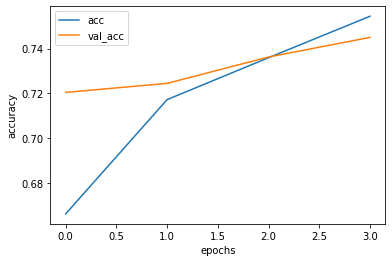

In [ ]:
plt.plot(history.history['accuracy'], label = "acc")
plt.plot(history.history['val_accuracy'],label = "val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

PERDIDA

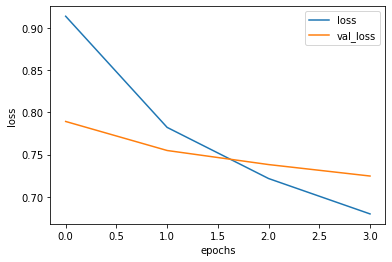

In [ ]:
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

## 4. FINAL MODEL 

### 4.1 Evaluation / Confusion Matrix 

In [ ]:
classes = data['category'].value_counts().index

In [ ]:
def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X,maxlen= max_length,padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()                
    return pred_value

Evaluación/ predicción mediante el datset de prueba - test f1

In [ ]:
y_pred = prediction(X_test)
print(classification_report(np.asarray(y_test),np.asarray( y_pred)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       501
           1       0.81      0.75      0.78       513
           2       0.69      0.70      0.69       488
           3       0.75      0.79      0.77       483
           4       0.73      0.77      0.75       531
           5       0.74      0.68      0.71       479

    accuracy                           0.76      2995
   macro avg       0.76      0.76      0.76      2995
weighted avg       0.76      0.76      0.76      2995



Matriz de confusión para validación de asertividad por clase en dataset de prueba (Test)

Text(32.99999999999999, 0.5, 'Real class')

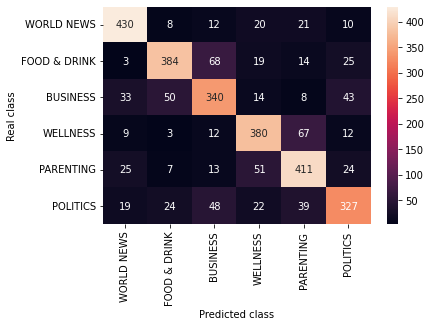

In [ ]:
confu_matrix = confusion_matrix(y_test, y_pred)

heatmap = sns.heatmap(confu_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')

plt.xlabel('Predicted class')
plt.ylabel('Real class')

dConclusión

Observamos que con 4 epochs es resultado es bastante similar al caso de los 9 epochs, esta prueba sobre todo se realizó para validar que no existiera un sobreentrenamiento u overfitting del modelo.

Por otro ladoGloVe, sin duda es un modelo que en este caso nos ha brindado con base a su pricipio de KNN, una muy buena etapa de pre-procesamiento antes de nuestra red neuronal de tipo LSTM.

*También es importante destacar que como bien dice la documentación de GloVe "GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus"*, este modelo está basado en la concurrencia de las palabras en nuestro corpus, además de que para el caso específico empleado de GloVe, se ha utilizado a glove.6B.100d que destaca por contener vectores de tamaño considerablemente pequeño (es decir, cada documento es pequeño similar por ejemplo a un tweet), precisamente esa es la razón de el por qué se ha empleado una red de tipo LSTM.
